# Machine Learning Project to Predict Stock Market Activity
*Created by Jordan Rust and Jenelle Dobyns*

## Introduction

The goal of this project is to be able to predict the future value of a company's stock. This is a difficult task, as predicting how the stock market will perform involves many factors. The share prices are dynamic and volatile, meaning the predictions will be difficult to make with high accuracy.

## Methods

To accomplish this, we will be using Long Short-Term Memory (LSTM) network. This is a recurrent neural network for learning long-term dependencies, commonly used for predicting time-series data. Sounds like a perfect fit for our stock market prediction problem!

For the purpose of this assignment, we will use technical analysis to determine how stocks may change. This means measurable data from stock market activities (stock prices, returns, volume of trades, etc.). This data is relatively short-termed and affected by current events, so the accuracy of our predictions will decrease the further in the future we go.

Jordan Rust's Work: 
- Found original dataset (Microsoft data)
- worked on data preprocessing
- set up original LSTM model with optimal parameters
- experimented with correlational analysis and non-time series models (random forest)
- contributed toward writing analysis

Jenelle Dobyns's Work:
- Adjusted dataset (Etsy)
- set up input/output data and different time horizons
- modified scalers to inverse output data before plotting
- set up bi-directional LSTM and 1D-CNN
- set up feature performance analysis
- contributed toward writing analysis

### The Dataset

Predicting the stock market requires a focused approach, so the first step will be looking into one company at a time.

Jenelle will be working at Etsy after graduation and they have granted her RSUs to be vested over 4 years. What a great time to learn about the stock market! Let's use Etsy's historical price data for our dataset. They went public on April 15, 2015, so we have about 8 years of daily data to work with. Our imported dataset includes the following information:

| Term       | Description |
| :----------- | :-----------  |
| Date        | Day market was open          |
| Open        | Price from the first transaction of a trading day | 
| High        | Maximum price in a trading day        |
| Low        | Minimum price in a trading day        |
| Close        | Price from the last transaction of a trading day        |
| Adjacent Close  | Closing price adjusted     |
| Volume        | Number of units traded in a day   |

After working with Etsy's stock data we will move on to other companies, such as Microsoft and GME

### The Process

First we need to get the data into a workable state. From there we create our model and fit our data to the model. Once it is trained, we can determine how accurate our predictions are to the real data and refine our model as needed. 

We will also be comparing our standard LSTM model performance to 2 other models - a bi-directional LSTM and a 1D CNN. 

To determine the ranking of models, we will use Root Mean Square Deviation (RMSE) and r^2 values. We'll also get our results into some plots so we can visualize the performance of our models.

Afterward, we're going to take a look at which features are the most and least important to our model predictions. We'll take all of this information and analyze it in the context of stock price analysis (do you think we can become millionaires after this???).



We need the following libraries to retrieve, process, and work with the data

In [ ]:
#Importing the Libraries
import pandas as pd                  
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

Now we just need to get the csv sheet, one can be found [here](https://finance.yahoo.com/quote/ETSY/history). This dataset is from when Etsy first went public (2015) to present

In [ ]:
#Import our dataset
df=pd.read_csv('ETSY.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.loc['2015']

C:\Users\Jason\AppData\Local\Temp\ipykernel_3256\149798867.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv('ETSY.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-16,31.000000,35.740002,28.219999,30.000000,30.000000,19763300
2015-04-17,29.770000,30.299999,26.510000,27.580000,27.580000,3965500
2015-04-20,28.770000,28.900000,24.870001,24.900000,24.900000,3076200
2015-04-21,24.969999,26.040001,24.559999,25.750000,25.750000,2184700
2015-04-22,26.000000,26.240000,24.950001,25.120001,25.120001,1442500
...,...,...,...,...,...,...
2015-12-24,8.810000,9.020000,8.760000,8.920000,8.920000,335400
2015-12-28,8.840000,8.920000,8.400000,8.520000,8.520000,1065100
2015-12-29,8.520000,8.600000,8.230000,8.510000,8.510000,792800


Upon importing, we asked any N/A values to be written as Null. Let's see if we have any null values in our dataset.  This isn't something we would expect since all the information is recorded daily, but it's good to double check.

If we do have Null values and left them, it would alter our results, as they are viewed as Outliers.

all we do is start with looking at the shape of the DataFrame. From there we can use isnull() to determine if we have any null values present

In [ ]:
# Check for Null values
# 
print("Shape: ", df.shape)
#See if we have any null values present
print("Are there Null: ", df.isnull().values.any())

Shape:  (2029, 6)
Are there Null:  False


Great! As expected, we don't have any null values in our data. Let's move on.

In predicting future stock prices, we are most interested in Adj Close, the closing price on that market day for the stock. We will be using this to determine how accurate our model is.

<Axes: xlabel='Date'>

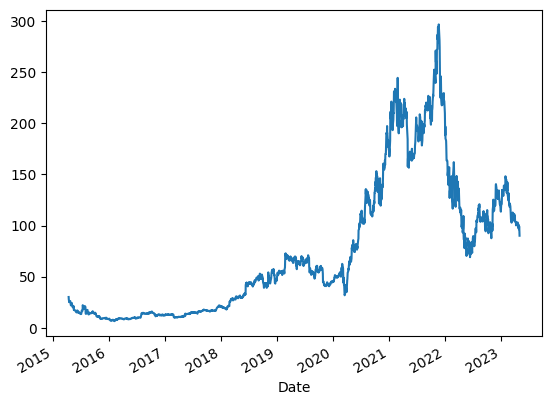

In [ ]:
df['Adj Close'].plot()

Here we can see Etsy's historical Adj Close since they went public. Pretty neat to see how they have weathered the economy through the pandemic.

Our Adj Close data will be our target variable for this experiment. Additionally, we have the following features to use for training:

- Open
- High
- Low
- Volume

In [ ]:
#Target Variable (aka dependent variable)
output = pd.DataFrame(df['Adj Close'])

features = ['Open', 'High', 'Low', 'Close']

Now we have a dataframe with just our target variable and the dates.

In [ ]:
output

,Adj Close
Date,
2015-04-16,30.000000
2015-04-17,27.580000
2015-04-20,24.900000
2015-04-21,25.750000
2015-04-22,25.120001
...,...
2023-05-01,96.269997
2023-05-02,99.190002
2023-05-03,98.964996


There is a lot of data to go through, and our first step is normalizing our data for better processing results. To do this, we will be using MinMaxScaler, which can be implemented by the method below [1].


*X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))*

*X_scaled = X_std * (max - min) + min*


Normalizing our data will ensure uniformity. We will be inverse scaling our data before plotting.


In [ ]:
# Normalize the features
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)

Here was what the old values looked like:

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-16,31.000000,35.740002,28.219999,30.000000,30.000000,19763300
2015-04-17,29.770000,30.299999,26.510000,27.580000,27.580000,3965500
2015-04-20,28.770000,28.900000,24.870001,24.900000,24.900000,3076200
2015-04-21,24.969999,26.040001,24.559999,25.750000,25.750000,2184700
2015-04-22,26.000000,26.240000,24.950001,25.120001,25.120001,1442500


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-01,100.360001,100.910004,95.440002,96.269997,96.269997,3951400
2023-05-02,94.559998,99.639999,94.379997,99.190002,99.190002,3590500
2023-05-03,99.190002,102.309998,98.059998,98.964996,98.964996,6566600
2023-05-04,96.540001,96.845001,90.739998,92.550003,92.550003,8317900
2023-05-05,93.699997,95.864998,89.139999,90.000000,90.000000,6990400


Notice how large these values are?

And here are the new scaled down values



In [ ]:
feature_transform.head()

,Open,High,Low,Close
Date,,,,
2015-04-16,0.082460,0.096072,0.077169,0.081363
2015-04-17,0.078342,0.077994,0.071220,0.073034
2015-04-20,0.074994,0.073342,0.065514,0.063810
2015-04-21,0.062272,0.063838,0.064435,0.066736
2015-04-22,0.065720,0.064502,0.065792,0.064567


In [ ]:
feature_transform.tail()

,Open,High,Low,Close
Date,,,,
2023-05-01,0.314674,0.312641,0.311043,0.309448
2023-05-02,0.295256,0.308421,0.307355,0.319498
2023-05-03,0.310757,0.317294,0.320159,0.318723
2023-05-04,0.301885,0.299133,0.294691,0.296644
2023-05-05,0.292377,0.295876,0.289124,0.287868


Now the data is much smaller and easier to work with. This will help with computation times and overall computer workload.

In [ ]:
# Create a separate scaler for the output
output_scaler = MinMaxScaler()
output_transform = output_scaler.fit_transform(output)

Now that the data is in a state we can work with, we are going to split it into train and test sets. 

We've decided to split our train/test split 80/20, like so:

In [ ]:
def split_data(horizon, feature_transform, output_transform):
    train_size = int(len(feature_transform) * 0.8)
    train_features, test_features = feature_transform.iloc[:train_size], feature_transform.iloc[train_size - horizon:]
    train_output, test_output = output_transform[:train_size], output_transform[train_size - horizon:]
    return train_features, test_features, train_output, test_output

We want to see our model predict 1, 7, and 30 days in advance. Our LSTM will require input/output pairs for each prediction horizon (1, 7, and 30).

In [ ]:
def create_dataset(X, y, time_steps, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - horizon + 1):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps + horizon - 1])
    return np.array(Xs), np.array(ys)


In [ ]:
# Split the data for 1-day, 7-day, and 30-day ahead predictions
X_train_1, X_test_1, y_train_1, y_test_1 = split_data(1, feature_transform, output_transform)
X_train_7, X_test_7, y_train_7, y_test_7 = split_data(7, feature_transform, output_transform)
X_train_30, X_test_30, y_train_30, y_test_30 = split_data(30, feature_transform, output_transform)

# Prepare the input data for LSTM by using the create_dataset function
X_train_1, y_train_1 = create_dataset(X_train_1.values, y_train_1, time_steps=1)
X_test_1, y_test_1 = create_dataset(X_test_1.values, y_test_1, time_steps=1)

X_train_7, y_train_7 = create_dataset(X_train_7.values, y_train_7, time_steps=1)
X_test_7, y_test_7 = create_dataset(X_test_7.values, y_test_7, time_steps=1)

X_train_30, y_train_30 = create_dataset(X_train_30.values, y_train_30, time_steps=1)
X_test_30, y_test_30 = create_dataset(X_test_30.values, y_test_30, time_steps=1)

#### Now that the data is ready, let's get some understanding of our first model: LSTM, or Long Short-Term Memory network.

This is a architecture that was introduced to help solve the problem of vanishing and expoloding gradients [6].

The LSTM model has a few expressions it uses, called gates. There are forget, input, and output gates.
LSTM preserves information from inputs that have already passed through it using the hidden state [7].

After processing the data above, we now have our input-output pairs. We're ready to set up our LSTM network!

Since we'll be running this across 3 different input-output pairs, let's define a function that can train our LSTM models and evaluate the results:

In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, epochs=50, batch_size=8):
    model = Sequential()
    model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Inverse scale the test outputs
    y_test = output_scaler.inverse_transform(y_test)

    # Inverse scale the predictions
    y_pred = output_scaler.inverse_transform(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)



    return model, rmse, r2, y_pred

We will be using Root Mean Squared Error (RMSE) and R2 to determine how effective our model is performing. The goal is to have a low RMSE value and a high R2 value. 

RMSE is a measure of how well a model can predict a value based on residuals between the predicted and observed values. This is a scale-dependent value, so we will be looking at our results after scaling our values to the appropriate measure and consider that in context.

R^2 is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. These values range from 0 to 1. An r^2 value of 1 (or 100%) indicatest hat ALL changes in the dependent variable are completely explained by changes in the independent variable or variables. However, we must remember that a high R^2 value doesn't necessarily indicate an adequate regression model - it could signify overfitting, etc.

In addition to these two metrics, we will be visualizing our data to get a robust analysis of how well our models perform.

Here we go... let's train our models!

In [ ]:
# Train and evaluate LSTM models for different horizons
model_1, rmse_1, r2_1, y_pred_1 = train_lstm(X_train_1, y_train_1, X_test_1, y_test_1)
model_7, rmse_7, r2_7, y_pred_7 = train_lstm(X_train_7, y_train_7, X_test_7, y_test_7)
model_30, rmse_30, r2_30, y_pred_30 = train_lstm(X_train_30, y_train_30, X_test_30, y_test_30)

Epoch 1/50
203/203 [==============================] - 1s 914us/step - loss: 0.0103
Epoch 2/50
203/203 [==============================] - 0s 877us/step - loss: 1.6990e-04
Epoch 3/50
203/203 [==============================] - 0s 879us/step - loss: 1.6585e-04
Epoch 4/50
203/203 [==============================] - 0s 894us/step - loss: 1.7076e-04
Epoch 5/50
203/203 [==============================] - 0s 887us/step - loss: 1.6361e-04
Epoch 6/50
203/203 [==============================] - 0s 884us/step - loss: 1.6405e-04
Epoch 7/50
203/203 [==============================] - 0s 857us/step - loss: 1.7425e-04
Epoch 8/50
203/203 [==============================] - 0s 879us/step - loss: 1.9867e-04
Epoch 9/50
203/203 [==============================] - 0s 882us/step - loss: 1.8222e-04
Epoch 10/50
203/203 [==============================] - 0s 865us/step - loss: 1.6632e-04
Epoch 11/50
203/203 [==============================] - 0s 877us/step - loss: 1.7796e-04
Epoch 12/50
203/203 [========================

Now that the models are trained, let's see how our RMSE and R^2 values are looking. 

In [ ]:
print("RMSE for 1-day prediction:", rmse_1)
print("R2 for 1-day prediction:", r2_1)

print("RMSE for 7-day prediction:", rmse_7)
print("R2 for 7-day prediction:", r2_7)

print("RMSE for 30-day prediction:", rmse_30)
print("R2 for 30-day prediction:", r2_30)

RMSE for 1-day prediction: 6.39322135739855
R2 for 1-day prediction: 0.9852768844791451
RMSE for 7-day prediction: 6.330950694248628
R2 for 7-day prediction: 0.9858974591888219
RMSE for 30-day prediction: 6.323603081461865
R2 for 30-day prediction: 0.98642439343247


We have a clue what's going on and which time horizon performs the best with our model, but let's look at the visualizations, too, before making any conclusions:

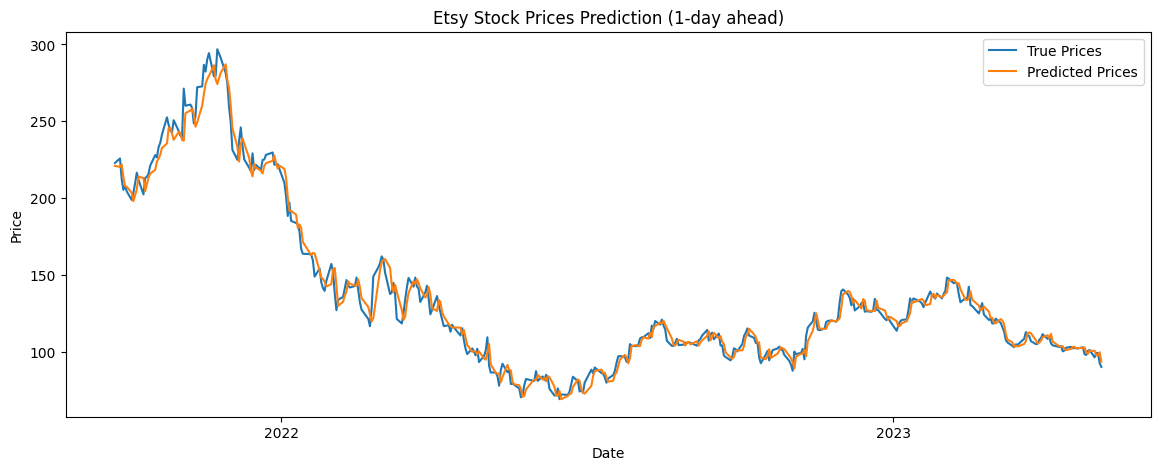

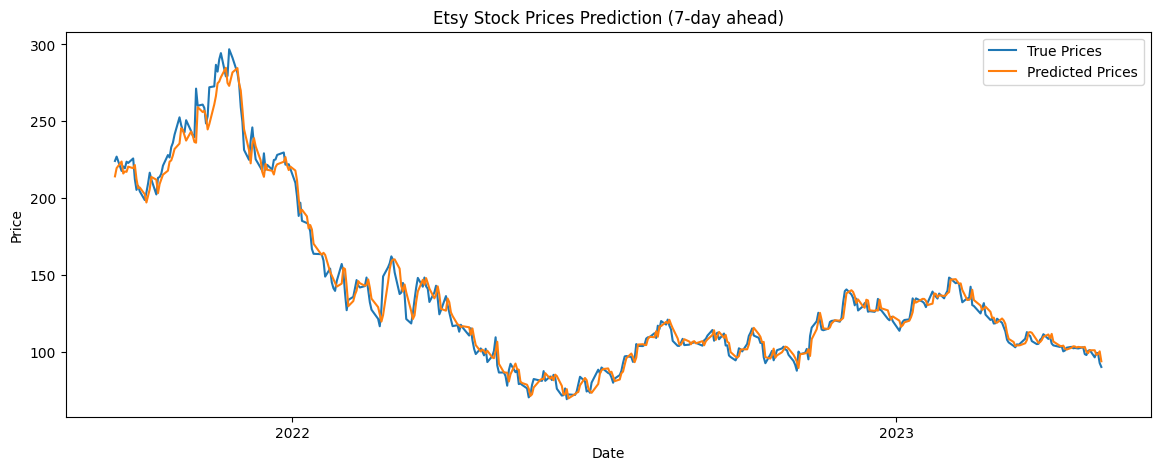

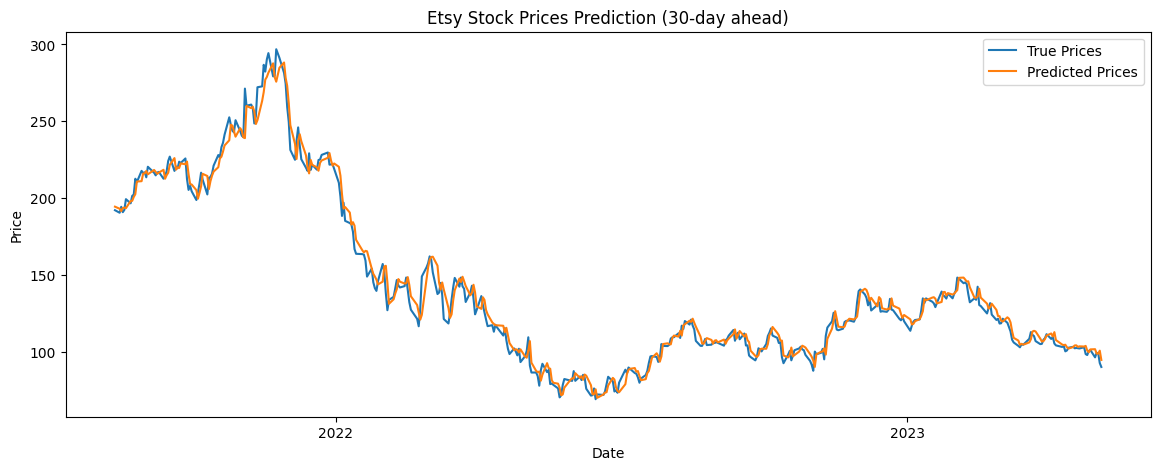

In [ ]:
import matplotlib.dates as mdates
def plot_predictions(y_test, y_pred, title, start_date):
    plt.figure(figsize=(14, 5))
    plt.plot(df.index[-len(y_test):], y_test, label='True Prices')
    plt.plot(df.index[-len(y_pred):], y_pred, label='Predicted Prices')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()

    # Set the x-axis to display years
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(years_fmt)

    plt.show()
    

# Inverse scale the test outputs
y_test_1_inverse = output_scaler.inverse_transform(y_test_1)
y_test_7_inverse = output_scaler.inverse_transform(y_test_7)
y_test_30_inverse = output_scaler.inverse_transform(y_test_30)

# # Inverse scale the predictions
# y_pred_1 = output_scaler.inverse_transform(y_pred_1)
# y_pred_7 = output_scaler.inverse_transform(y_pred_7)
# y_pred_30 = output_scaler.inverse_transform(y_pred_30)

# Plot predictions
plot_predictions(y_test_1_inverse, y_pred_1, "Etsy Stock Prices Prediction (1-day ahead)", df.index[-len(y_test_1_inverse):].min())
plot_predictions(y_test_7_inverse, y_pred_7, "Etsy Stock Prices Prediction (7-day ahead)", df.index[-len(y_test_7_inverse):].min())
plot_predictions(y_test_30_inverse, y_pred_30, "Etsy Stock Prices Prediction (30-day ahead)", df.index[-len(y_test_30_inverse):].min())

Awesome, something to visualize! Here we can see how our models perform on our test data, the last 20% of our Etsy stock data (which is the reason why the data only spans over 2022-23).

There are some key things we can take away from these RMSE and R^2 vals and the corresponding true/predicted plots:

One, the architecture we settled on for our LSTM is providing overall very accurate predictions for 1-day, 7-day, and 30-day horizons - our unstandardized RMSE and R^2 values are pretty similar:

In [ ]:
print("RMSE for 1-day prediction:", rmse_1)
print("R2 for 1-day prediction:", r2_1)
print()
print("RMSE for 7-day prediction:", rmse_7)
print("R2 for 7-day prediction:", r2_7)
print()
print("RMSE for 30-day prediction:", rmse_30)
print("R2 for 30-day prediction:", r2_30)

RMSE for 1-day prediction: 6.39322135739855
R2 for 1-day prediction: 0.9852768844791451

RMSE for 7-day prediction: 6.330950694248628
R2 for 7-day prediction: 0.9858974591888219

RMSE for 30-day prediction: 6.323603081461865
R2 for 30-day prediction: 0.98642439343247


Two, we can see, as expected, that our RMSE decreases slightly as our horizon increases. This makes sense, because it's easier for our model to accurately predict 1 day ahead than 7 or 30 days ahead. This is likely due to increased noise and randomness introduced over longer periods of time, as well as the non-stationary nature of stock prices over time.

Moving forward, let's stick to our 1-day time horizon since we get the best RMSE and R2 values with that.

## How do other models compare?



### Bi-Directional LSTM


BiLSTMs are usually used on natural language processing. Unlike a unidirectional (standard) LSTM like our model above, input flows in both directions. This works by adding one more LSTM layer that reverses the direction of information flow. We can then combine the outputs from both layers to optimize our model [5].

A Bi-LSTM combines two separate LSTMs to process the input sequence in both directions.

An advantage to using this model of just an LSTM is this model can capture dependencies in both directions, letting the model better understand the context of each step.


In [ ]:
def train_lstm_bidir(X_train, y_train, X_test, y_test, epochs=50, batch_size=8):
    model = Sequential()
    model.add(Bidirectional(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Inverse scale the test outputs
    y_test = output_scaler.inverse_transform(y_test)

    # Inverse scale the predictions
    y_pred = output_scaler.inverse_transform(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return model, rmse, r2, y_pred

Now that we have a way to train the bi-LSTM model, we will feed it our data again

In [ ]:
# Train and evaluate LSTM bidirectional model
model_1_bd, rmse_1_bd, r2_1_bd, y_pred_1_bd = train_lstm_bidir(X_train_1, y_train_1, X_test_1, y_test_1)

Epoch 1/50
203/203 [==============================] - 3s 976us/step - loss: 0.0042
Epoch 2/50
203/203 [==============================] - 0s 929us/step - loss: 1.6117e-04
Epoch 3/50
203/203 [==============================] - 0s 929us/step - loss: 1.6776e-04
Epoch 4/50
203/203 [==============================] - 0s 926us/step - loss: 1.6392e-04
Epoch 5/50
203/203 [==============================] - 0s 926us/step - loss: 1.8335e-04
Epoch 6/50
203/203 [==============================] - 0s 926us/step - loss: 1.7718e-04
Epoch 7/50
203/203 [==============================] - 0s 929us/step - loss: 2.2645e-04
Epoch 8/50
203/203 [==============================] - 0s 919us/step - loss: 2.0587e-04
Epoch 9/50
203/203 [==============================] - 0s 974us/step - loss: 1.7691e-04
Epoch 10/50
203/203 [==============================] - 0s 926us/step - loss: 1.6535e-04
Epoch 11/50
203/203 [==============================] - 0s 926us/step - loss: 2.0272e-04
Epoch 12/50
203/203 [========================

In [ ]:
print("RMSE for 1-day prediction:", rmse_1_bd)
print("R2 for 1-day prediction:", r2_1_bd)

RMSE for 1-day prediction: 6.3744574960915505
R2 for 1-day prediction: 0.9853631812213544


Again we have a low RMSE and a high r^2

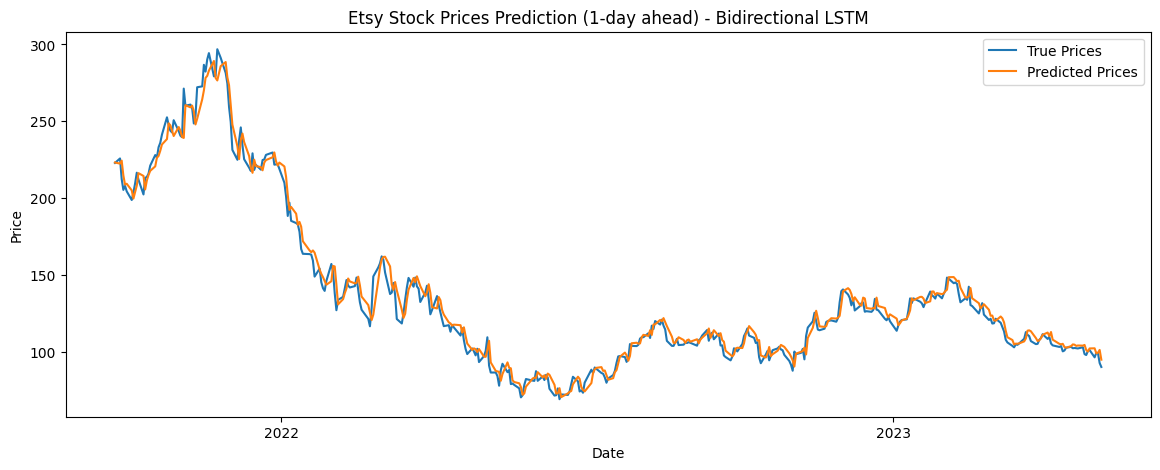

In [ ]:
plot_predictions(y_test_1_inverse, y_pred_1_bd, "Etsy Stock Prices Prediction (1-day ahead) - Bidirectional LSTM",  start_date=df.index[-len(y_test_1_inverse):].min())

In [ ]:
print("RMSE for 1-day prediction (LSTM):", rmse_1)
print("R2 for 1-day prediction (LSTM):", r2_1)
print("RMSE for 1-day prediction (Bidir LSTM):", rmse_1_bd)
print("R2 for 1-day prediction (Bidir LSTM):", r2_1_bd)

RMSE for 1-day prediction (LSTM): 6.39322135739855
R2 for 1-day prediction (LSTM): 0.9852768844791451
RMSE for 1-day prediction (Bidir LSTM): 6.3744574960915505
R2 for 1-day prediction (Bidir LSTM): 0.9853631812213544


Looks like a bidirectional LSTM is even more accurate than our original LSTM with the same architecture otherwise. Nice! Although, looking at the values above, the difference is pretty negligible. Still, optimizing our stock market predictor means more hypothetical money in our pocket.

1D Convolutional Neural Network (1D-CNN) is the next model being tested. 1D-CNN works well with timer series data like what we have.

The configuration of 1D-CNN models is formed by these hyper-parameters [8]:


*   Number of hidden layers
*   Filter, or kernel, size in each layer
*   Subsampling factor in each layer
*   Pooling and activiation functions



### 1D-CNN

In [ ]:
def train_cnn(X_train, y_train, X_test, y_test, epochs=50, batch_size=8):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Inverse scale the test outputs
    y_test = output_scaler.inverse_transform(y_test)

    # Inverse scale the predictions
    y_pred = output_scaler.inverse_transform(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return model, rmse, r2, y_pred

Now that we have a function that can train the model, we just need to feed it the data

In [ ]:
# Train and evaluate 1D CNN model
model_1_cnn, rmse_1_cnn, r2_1_cnn, y_pred_1_cnn = train_cnn(X_train_1, y_train_1, X_test_1, y_test_1)

Epoch 1/50
203/203 [==============================] - 0s 562us/step - loss: 0.0032
Epoch 2/50
203/203 [==============================] - 0s 545us/step - loss: 1.4988e-04
Epoch 3/50
203/203 [==============================] - 0s 545us/step - loss: 1.5250e-04
Epoch 4/50
203/203 [==============================] - 0s 545us/step - loss: 1.4826e-04
Epoch 5/50
203/203 [==============================] - 0s 550us/step - loss: 1.5449e-04
Epoch 6/50
203/203 [==============================] - 0s 547us/step - loss: 1.5792e-04
Epoch 7/50
203/203 [==============================] - 0s 545us/step - loss: 1.6128e-04
Epoch 8/50
203/203 [==============================] - 0s 545us/step - loss: 1.5367e-04
Epoch 9/50
203/203 [==============================] - 0s 543us/step - loss: 1.5446e-04
Epoch 10/50
203/203 [==============================] - 0s 540us/step - loss: 1.6361e-04
Epoch 11/50
203/203 [==============================] - 0s 567us/step - loss: 1.5587e-04
Epoch 12/50
203/203 [========================

In [ ]:
print("RMSE for 1-day prediction:", rmse_1_cnn)
print("R2 for 1-day prediction:", r2_1_cnn)

RMSE for 1-day prediction: 7.619950216168683
R2 for 1-day prediction: 0.9790846804440514


As we can see, the RMSE is low and r^2 is high, however, our RMSE is the highest of all 3 of our models. 

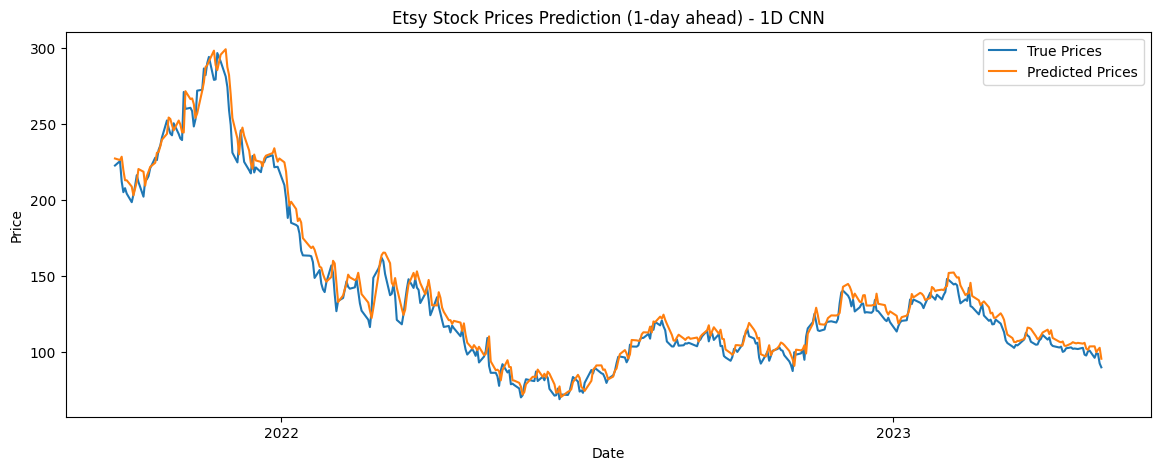

In [ ]:

plot_predictions(y_test_1_inverse, y_pred_1_cnn, "Etsy Stock Prices Prediction (1-day ahead) - 1D CNN",  df.index[-len(y_test_1_inverse):].min())

In [ ]:
print("RMSE for 1-day prediction LSTM:", rmse_1)
print("R2 for 1-day prediction LSTM:", r2_1)
print("RMSE for 1-day prediction CNN:", rmse_1_cnn)
print("R2 for 1-day prediction CNN:", r2_1_cnn)

RMSE for 1-day prediction LSTM: 6.39322135739855
R2 for 1-day prediction LSTM: 0.9852768844791451
RMSE for 1-day prediction CNN: 7.619950216168683
R2 for 1-day prediction CNN: 0.9790846804440514


Our 1D-CNN model is also very accurate with these parameters. It looks like we've been able to consistently achieve low RMSEs and R2 values close to 1 for each of our models.

# Further analysis

Let's see what further analysis we can do aside from calculating the RMSE and R2 values of our models. We're curious to see how our models work on different datasets...

### Microsoft data

Here is the data for Microsoft's stock history, from 1986 to 2022. We will do the same things we did with the Etsy data before we can start processing it

In [ ]:
msft_df=pd.read_csv('MSFT.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

msft_output = pd.DataFrame(msft_df['Adj Close'])

msft_features = ['Open', 'High', 'Low', 'Close']

msft_feature_transform = scaler.fit_transform(msft_df[msft_features])
msft_feature_transform = pd.DataFrame(columns=msft_features, data=msft_feature_transform, index=msft_df.index)

msft_output_transform = output_scaler.fit_transform(msft_output)

X_train_msft, X_test_msft, y_train_msft, y_test_msft = split_data(1, msft_feature_transform, msft_output_transform)

X_train_msft, y_train_msft = create_dataset(X_train_msft.values, y_train_msft, time_steps=1)
X_test_msft, y_test_msft = create_dataset(X_test_msft.values, y_test_msft, time_steps=1)

C:\Users\Jason\AppData\Local\Temp\ipykernel_3256\689691648.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  msft_df=pd.read_csv('MSFT.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)


Now we have the data in a usable state, we are going to use our LSTM model with the data. First we are going to train the model

In [ ]:
# LSTM
model_msft, rmse_msft, r2_msft, y_pred_msft = train_lstm(X_train_msft, y_train_msft, X_test_msft, y_test_msft)

# BiLSTM
model_msft_b, rmse_msft_b, r2_msft_b, y_pred_msft_b = train_lstm_bidir(X_train_msft, y_train_msft, X_test_msft, y_test_msft)

# 1D-CNN
model_msft_c, rmse_msft_c, r2_msft_c, y_pred_msft_c = train_cnn(X_train_msft, y_train_msft, X_test_msft, y_test_msft)

Epoch 1/50
909/909 [==============================] - 2s 870us/step - loss: 9.7725e-05
Epoch 2/50
909/909 [==============================] - 1s 866us/step - loss: 4.7536e-05
Epoch 3/50
909/909 [==============================] - 1s 869us/step - loss: 4.6246e-05
Epoch 4/50
909/909 [==============================] - 1s 862us/step - loss: 4.5083e-05
Epoch 5/50
909/909 [==============================] - 1s 869us/step - loss: 4.6588e-05
Epoch 6/50
909/909 [==============================] - 1s 900us/step - loss: 4.5134e-05
Epoch 7/50
909/909 [==============================] - 1s 889us/step - loss: 4.6044e-05
Epoch 8/50
909/909 [==============================] - 1s 872us/step - loss: 4.4554e-05
Epoch 9/50
909/909 [==============================] - 1s 865us/step - loss: 4.6064e-05
Epoch 10/50
909/909 [==============================] - 1s 875us/step - loss: 4.4458e-05
Epoch 11/50
909/909 [==============================] - 1s 879us/step - loss: 4.4276e-05
Epoch 12/50
909/909 [====================

Now we have the model trained, let's look at how well our models do on our MSFT data:

In [ ]:
print("RMSE for MSFT data (LSTM):", rmse_msft)
print("R2 for MSFT data (LSTM):", r2_msft)

print("RMSE for MSFT data (BiLSTM):", rmse_msft_b)
print("R2 for MSFT data (BiLSTM):", r2_msft_b)

print("RMSE for MSFT data (1dCNN):", rmse_msft_c)
print("R2 for MSFT data (1dCNN):", r2_msft_c)

RMSE for MSFT data (LSTM): 55.324611013926315
R2 for MSFT data (LSTM): 0.577530293778217
RMSE for MSFT data (BiLSTM): 54.839540983228986
R2 for MSFT data (BiLSTM): 0.5849059993768848
RMSE for MSFT data (1dCNN): 170.89531874956597
R2 for MSFT data (1dCNN): -3.031059118588998


This data suggests our model was not performing very well, at least compared to the other dataset. Let's visualize what's going on here:

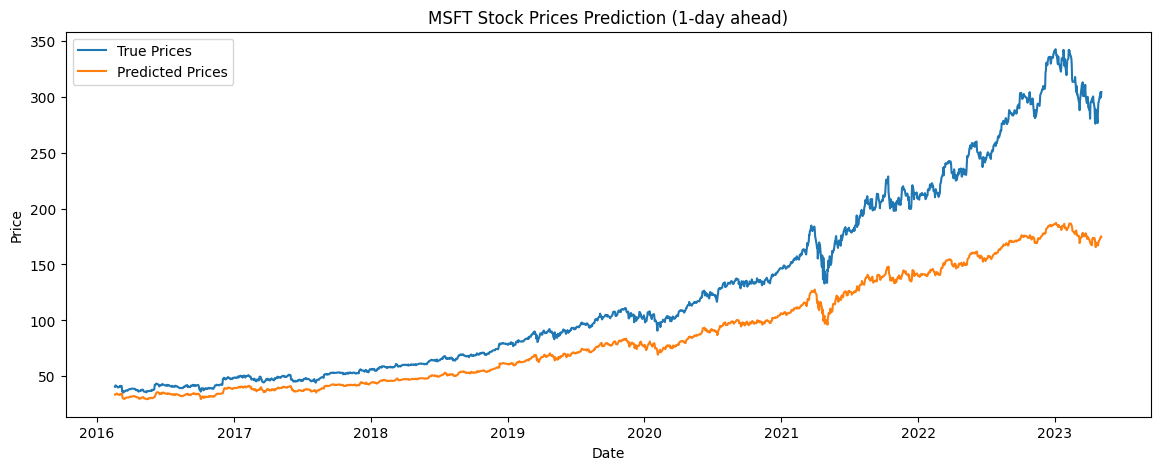

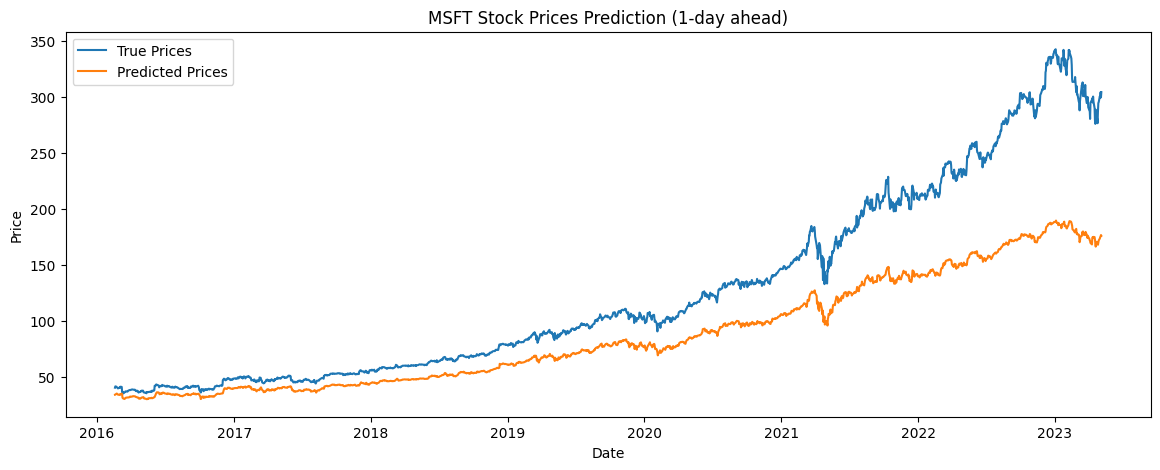

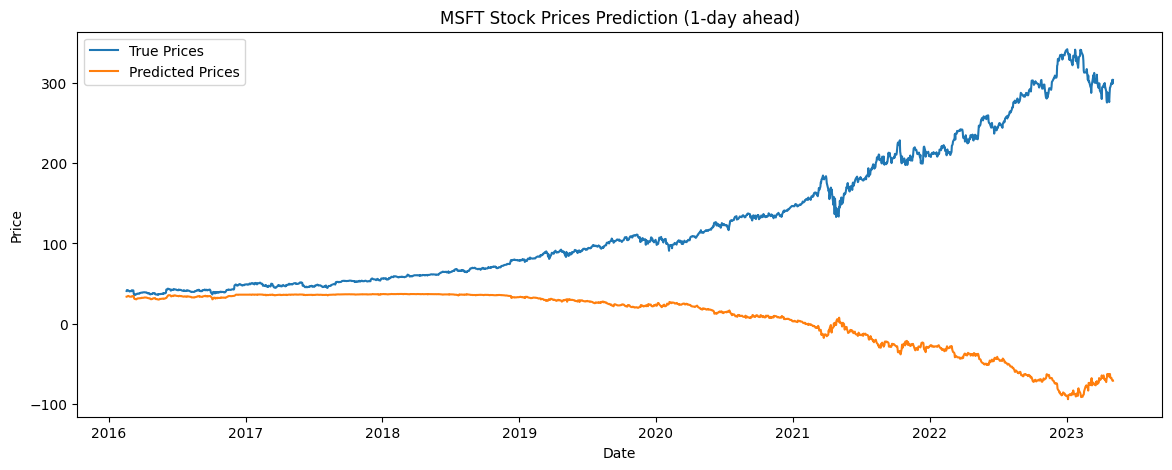

In [ ]:
# Inverse scale the test outputs
y_test_msft = output_scaler.inverse_transform(y_test_msft)

# Plot predictions
plot_predictions(y_test_msft, y_pred_msft, "MSFT Stock Prices Prediction (1-day ahead)", df.index[-len(y_test_1_inverse):].min())

plot_predictions(y_test_msft, y_pred_msft_b, "MSFT Stock Prices Prediction (1-day ahead)", df.index[-len(y_test_1_inverse):].min())

plot_predictions(y_test_msft, y_pred_msft_c, "MSFT Stock Prices Prediction (1-day ahead)", df.index[-len(y_test_1_inverse):].min())

It looks like our model is under-predicting our MSFT stock prices, with the gap widening the further time goes on. With some thought, we can see why this might be the case:

Our model was trained on MSFT stock price data from 1985 - 2016, where the maximum stock price was less than $50 per share. In the time since 2016, Microsoft has seen a long-term upward trend -- a trend that was not quite present in our training dataset. It makes sense, then, that our model would err on the side of under-valuing our MSFT stock -- the trends we see from 2016-present just weren't available in our training data.

This was surprising to us, as we figured our models would do better with more stable and less volatile data, especially over a longer period of time. However, understanding the limitations of LSTM when it comes to time series forecasting, and understanding the data that was fed through our train dataset vs. the data we sicced our model on, we can see why this is the case.

### Volatile data

Well, working with lots of fairly stable MSFT data didn't quite give us the results we were expecting. Let's turn this on its head and give our model some REALLY volatile data... $GME, anyone?

C:\Users\Jason\AppData\Local\Temp\ipykernel_3256\1532218638.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  GME_df=pd.read_csv('GME.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)


<Axes: xlabel='Date'>

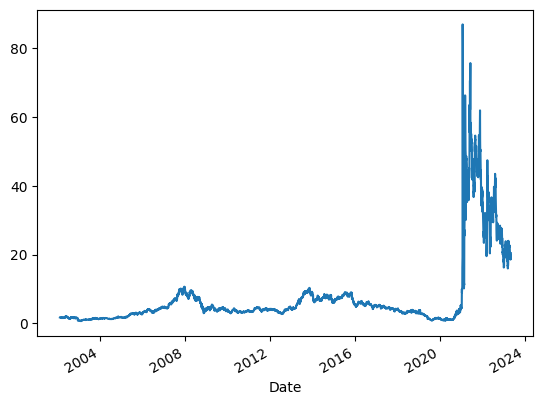

In [ ]:
GME_df=pd.read_csv('GME.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

GME_df['Adj Close'].plot()

Here's what our Adjusted Closing prices for GameStop look like. This looks like it will be a problem for our model... we will be training on the first 80% of their historical data, which as we can see is a pretty consistent price with a few bumps. What's going to happen when we test our model on the craziness that is 2020 - present?

In [ ]:

GME_output = pd.DataFrame(GME_df['Adj Close'])

GME_features = ['Open', 'High', 'Low', 'Close']

GME_feature_transform = scaler.fit_transform(GME_df[GME_features])
GME_feature_transform = pd.DataFrame(columns=GME_features, data=GME_feature_transform, index=GME_df.index)

In [ ]:

GME_output_transform = output_scaler.fit_transform(GME_output)

X_train_GME, X_test_GME, y_train_GME, y_test_GME = split_data(1, GME_feature_transform, GME_output_transform)

X_train_GME, y_train_GME = create_dataset(X_train_GME.values, y_train_GME, time_steps=1)
X_test_GME, y_test_GME = create_dataset(X_test_GME.values, y_test_GME, time_steps=1)

In [ ]:
# LSTM
model_GME, rmse_GME, r2_GME, y_pred_GME = train_lstm(X_train_GME, y_train_GME, X_test_GME, y_test_GME)
# BiLSTM
model_GME_b, rmse_GME_b, r2_GME_b, y_pred_GME_b = train_lstm_bidir(X_train_GME, y_train_GME, X_test_GME, y_test_GME)
# 1D-CNN
model_GME_c, rmse_GME_c, r2_GME_c, y_pred_GME_c = train_cnn(X_train_GME, y_train_GME, X_test_GME, y_test_GME)

Epoch 1/50
535/535 [==============================] - 2s 896us/step - loss: 3.8442e-05
Epoch 2/50
535/535 [==============================] - 0s 873us/step - loss: 2.5602e-05
Epoch 3/50
535/535 [==============================] - 0s 892us/step - loss: 2.5079e-05
Epoch 4/50
535/535 [==============================] - 0s 894us/step - loss: 2.4232e-05
Epoch 5/50
535/535 [==============================] - 0s 871us/step - loss: 2.3518e-05
Epoch 6/50
535/535 [==============================] - 0s 883us/step - loss: 2.4311e-05
Epoch 7/50
535/535 [==============================] - 0s 874us/step - loss: 2.3818e-05
Epoch 8/50
535/535 [==============================] - 0s 903us/step - loss: 2.2980e-05
Epoch 9/50
535/535 [==============================] - 0s 894us/step - loss: 2.4174e-05
Epoch 10/50
535/535 [==============================] - 0s 880us/step - loss: 2.2326e-05
Epoch 11/50
535/535 [==============================] - 0s 890us/step - loss: 2.2972e-05
Epoch 12/50
535/535 [====================

In [ ]:
print("RMSE for GME data (LSTM):", rmse_GME)
print("R2 for GME data (LSTM):", r2_GME)

print("RMSE for GME data (BiLSTM):", rmse_GME_b)
print("R2 for GME data (BiLSTM):", r2_GME_b)

print("RMSE for GME data (1dCNN):", rmse_GME_c)
print("R2 for GME data (1dCNN):", r2_GME_c)

RMSE for GME data (LSTM): 13.358071548228144
R2 for GME data (LSTM): 0.4853617204771218
RMSE for GME data (BiLSTM): 13.043526222029161
R2 for GME data (BiLSTM): 0.5093129604805089
RMSE for GME data (1dCNN): 12.247686082361767
R2 for GME data (1dCNN): 0.5673640056029023


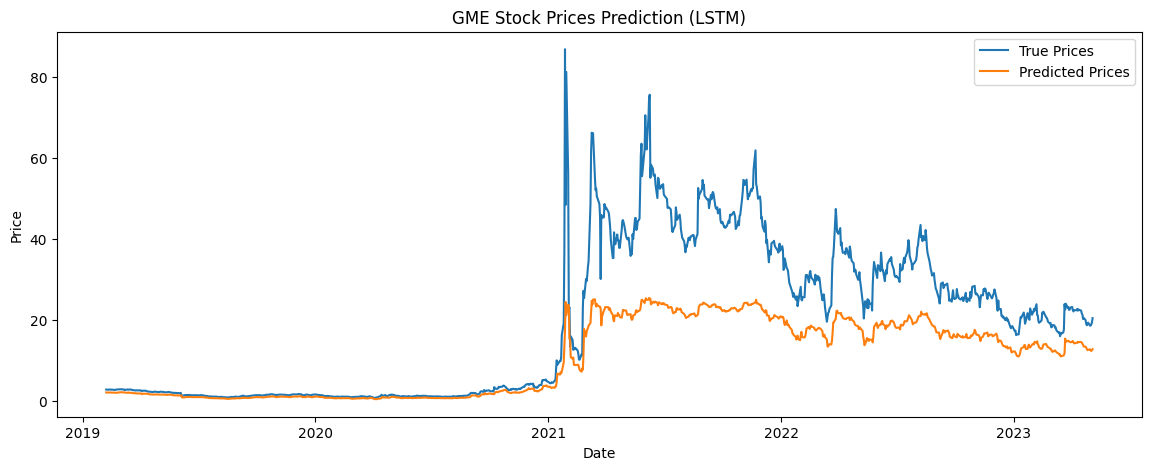

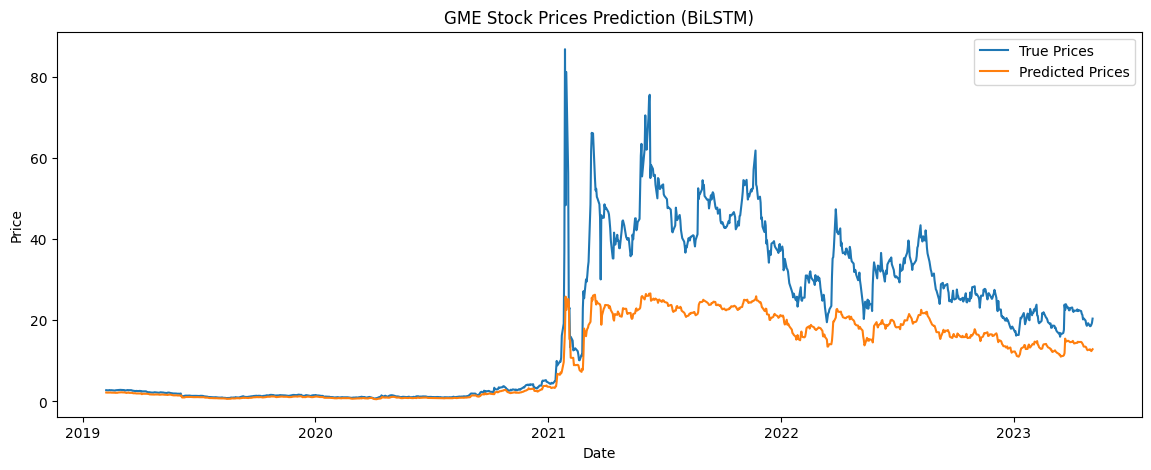

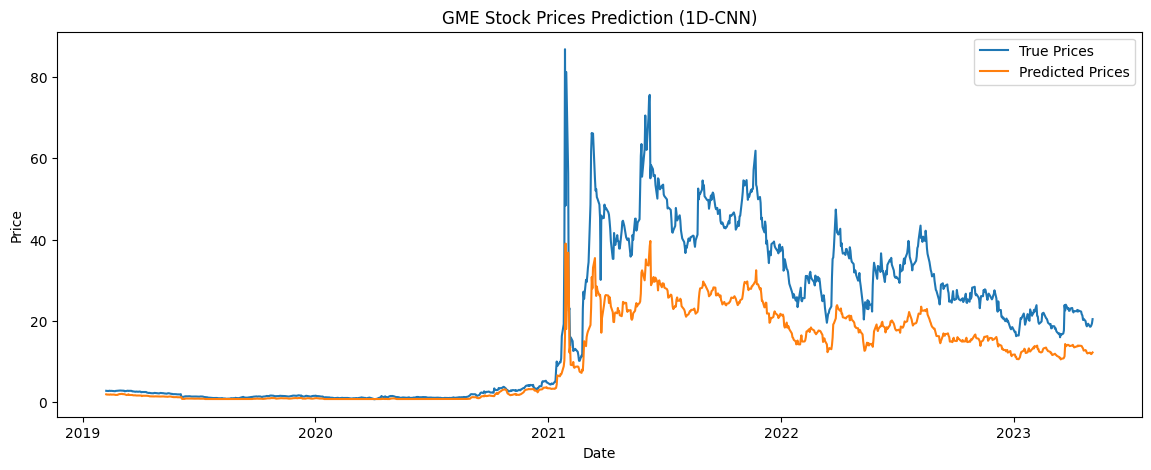

In [ ]:
# Inverse scale the test outputs
y_test_GME = output_scaler.inverse_transform(y_test_GME)

# Plot predictions
plot_predictions(y_test_GME, y_pred_GME, "GME Stock Prices Prediction (LSTM)", df.index[-len(y_test_GME):].min())

# Plot predictions
plot_predictions(y_test_GME, y_pred_GME_b, "GME Stock Prices Prediction (BiLSTM)", df.index[-len(y_test_GME):].min())

# Plot predictions
plot_predictions(y_test_GME, y_pred_GME_c, "GME Stock Prices Prediction (1D-CNN)", df.index[-len(y_test_GME):].min())

Oh, interesting! 

It looks like, when exposed to highly volatile data like GME with outside factors that aren't represented in our features, our models also aren't doing so hot. Look at how accurately our models predict leading up to 2021, compared to how consistently inconsistent they are afterward. After the early 2021 jump in stock price, our model consistently under-predicts GME stock price for the rest of the series. 

Notably, our 1D-CNN seems to do the best job handling the volatility in this GME test data. This is reflected in our RMSE and R2 values, too:

In [ ]:
print("RMSE for GME data (LSTM):", rmse_GME)
print("R2 for GME data (LSTM):", r2_GME)

print("RMSE for GME data (BiLSTM):", rmse_GME_b)
print("R2 for GME data (BiLSTM):", r2_GME_b)

print("RMSE for GME data (1dCNN):", rmse_GME_c)
print("R2 for GME data (1dCNN):", r2_GME_c)

RMSE for GME data (LSTM): 13.358071548228144
R2 for GME data (LSTM): 0.4853617204771218
RMSE for GME data (BiLSTM): 13.043526222029161
R2 for GME data (BiLSTM): 0.5093129604805089
RMSE for GME data (1dCNN): 12.247686082361767
R2 for GME data (1dCNN): 0.5673640056029023


How come our 1D-CNN is performing better on volatile data, but our LSTM and BiLSTM perform better on data more like Etsy's? There could be a few reasons for this...
- CNNs are generally pretty good at automatically detecting local/global features in data using their convolutional layers, which seems to be useful with volatile stock data where certain patterns or changes could be important predictors
- CNNs are often better than LSTMs at handling noisy data due to their structure. This is evident to us in our 1D-CNN visualization above where we see our model dealing with the high volatility from 2021-present way better than our LSTMs.
- Our CNN has more neurons in its dense layer (50 vs. 25), which we did earlier to try to optimize for our Etsy data. This could also be a factor in the performance on our volatile data


Still, overall, our models come up short when working with volatile data like GME stock. This is a limitation that is to be expected when working with volatile stock data. As we know, stock prices are influenced by so many factors other than what we can identify here. GME, for example, encountered a short squeeze saga in January 2021 when the Reddit users from r/wallstreetbets rallied together to gobble up GME stock amid their financial struggles.

How can you represent that in a model like this? How can you predict it?

This is a perfect example of why machine learning can only do so much when it comes to stock prediction. 

Another example to consider would be the Covid-19 pandemic. In March 2020, the S&P 500 fell more than 34% from its peak a month prior due to events and circumstances that were completely blindsiding. These are things that models like ours cannot predict.

### Feature Importance

Let's go back to our original LSTM model and see if we can figure out which of our 4 features are important in our predictions. Feature importance helps to identify the most critical features in a dataset, which can aid in understanding the underlying patterns and relationships in the data.

There are several techniques to find this, such as:
* Correlation
* Feature Selection Algorithms
* Decision trees
* Model-based methods

So what are the features of importance? let's see what permutation_importance can show us. Below, we'll make a function that can evaluate the performance of a model (in our case, the original LSTM from above), then run evaluation and compute the permutation importance for each of our features. We'll then compare the feature importance means and standard deviations and analyze our results.

In [ ]:
from sklearn.inspection import permutation_importance
# Define a function to evaluate the performance of the model
def evaluate_model(model, X_test, y_test):
    # Check shape of X_test
    if len(X_test.shape) == 2:
        # Reshape X_test to 3D if necessary
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Evaluate model performance
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Evaluate the original performance of the LSTM model
rmse_original, r2_original = evaluate_model(model_1, X_test_1, y_test_1)
print("Original RMSE:", rmse_original)
print("Original R2:", r2_original)


X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], -1))
# Compute permutation importance for each feature
result = permutation_importance(model_1, X_test_1, y_test_1, n_repeats=10, random_state=0, scoring=evaluate_model)

# Print feature importance scores
feature_names = ['Open', 'High', 'Low', 'Close']
print("Importance of variables on Etsy data:")
for i, (importance_mean, importance_std) in enumerate(zip(result.importances_mean, result.importances_std)):
    print(f"{feature_names[i]}: Mean Importance: {importance_mean[0]:.4f}, Std: {importance_std[0]:.4f}")

13/13 [==============================] - 0s 667us/step
Original RMSE: 0.022003859072850067
Original R2: 0.9852768845517633
13/13 [==============================] - 0s 625us/step
Importance of variables on Etsy data:
Open: Mean Importance: -0.0163, Std: 0.0008
High: Mean Importance: -0.0391, Std: 0.0015
Low: Mean Importance: -0.0524, Std: 0.0019
Close: Mean Importance: -0.0777, Std: 0.0027


After performing our permutation importance analysis on our original Etsy data, it looks like the 'Close' feature has the highest importance in predicting stock prices, followed by Low, High, and Open. This indicates that past closing prices have a stronger correlation with future prices than other features, such as opening prices or daily highs and lows. 
Notably, each of the features have negative mean importances, which means that random shuffling of their values affects the model's accuracy negatively. 
This information could be used to optimize and refine future feature selection when building models. For example, we could probably exclude 'Open' and 'High' features altogether. 

# Conclusions

### What did we learn?

The results obtained from our 3 models (LSTM, bidirectional LSTM, 1D-CNN) show very similar performance in terms of RMSE and R2 scores overall. The RMSE values are low, indicating that the models' had good performance and accurate, able to predict stock prices are close to the real prices. The R2 values are also high and close to 1, suggesting that the models can explain a significant portion of the variance in stock prices.

We also learned which of our features ('Close') was most beneficial toward our LSTM model's predictions, and which ones were least beneficial ('Open'). We would love to revisit this project one day and bring in some external data, like news sentiment analysis, to have more features to compare.

### What was difficult?

Time series analysis was a different beast than either of us were used to. It took quite a lot of research to understand the differences between standard and bidirectional LSTM and an LSTM and a 1D-CNN. We also considered including other models in our project, but the idea of including a non-time series analysis model seemed frivolous (especially after we learned more about the unique problems faced with time series analysis). 

Another difficulty was making sense of and analyzing our results in context. We were surprised when our MSFT data didn't perform as well as Etsy despite seeming more stable and having more data to work with. It took some research and a deeper understanding of how LSTMs work to understand why our results turned out the way that they did.

Our difficulties ended up contributing to our overall understanding of time series predicting tools like LSTMs, and helped us have a more robust look at the features and limitations of the tools we used.



### Ending thoughts

While these models seem to perform well in predicting stock prices, we must remember that stock market prediction is a complex task, and relying solely on these models for making investment decisions could be risky. This is because the models are trained on limited historical data. This limitation means that a model can't capture the full range of possible market dynamics. Unforeseen events not related to historical data, like pandemics or political changes, can significantly affect stock prices, and events such as these aren't represented in training data. 

Essentially, while our models can provide reasonably accurate predictions of Etsy stock prices, they are only one factor of many in making investment decisions. Additionally, there is much more opportunity for analysis on stock data, such as incorporating news sentiment analysis as an indicator on market behavior or including macroeconomic indicators such as interest rates or inflation. It could also be valuable to train the models on different subsets of the data, like from different time periods or during periods of different market conditions (e.g. bull vs. bear markets).

For further improvement in our model, there are several methods we can impliment
- Collecting more data
  - the more data we collect the better our models can learn the patterns
- Feature engineering
  - using the features we found to be important and potentially creating new features
- Hyper-parameter tuning
  - every machine learning model uses hyper-parameters that can be adjusted, so perhaps there is a better combination of them we can use
- Different model selection
  - just because the models we chose were fairly accurate doesn't mean there aren't other models that have a higher accuracy
- Regularization
  - prevent overfitting by adding a penalty term to the loss function, can improve the model's generalization
- Ensemble methods
  - Sometimes one method is not enough, so maybe we can combine multiple models to get better accuracy
- Cross-validation
  - we can split the data into multiple train and validate sets to get better estimates on how our model is running

Overall, these models provide valuable insight on what machine learning is capable of when predicting time series, and what its limitations are. 

Thank you for taking the time to read through our project, and thank you for a wonderful semester!

### References

[1] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

[3] https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

[4] https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why

[5] https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm

[6] https://www.baeldung.com/cs/nlp-encoder-decoder-models#1-what-are-vanishingexploding-gradients

[7] https://intellipaat.com/blog/what-is-lstm/?US

[8] Kiranyaz, Serkan, et al. “1d Convolutional Neural Networks and Applications: A Survey.” Mechanical Systems and Signal Processing, 14 Nov. 2020, www.sciencedirect.com/science/article/pii/S0888327020307846. 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import io
from nbformat import current
import glob
nbfile = glob.glob('Dobyns_Rust_Project_Final')
print(nbfile)
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

['Copy of Dobyns_Rust_Project_Final(1).ipynb']
Word count for file Copy of Dobyns_Rust_Project_Final(1).ipynb is 3580
